In [1]:
%matplotlib inline

## PyTorch Basics
### What is PyTorch?
It is a **replacement for NumPy** to use the power of GPUs, and a **deep learning research platform** that provides maximum flexibility and speed ([source](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)).

You can create a [PyTorch tensor](https://pytorch.org/docs/stable/tensors.html) in a similary way that you create a NumPy ndarray:

In [2]:
import numpy as np
import torch
print("torch version:", torch.__version__) # please use pytorch 1.0

print('\nCreate a zero ndarray in NumPy:')
zero_np = np.zeros([2, 3])
print(zero_np)
print('\nCreate a zero tensor in PyTorch:')
zero_pt = torch.zeros([2,3])
print(zero_pt)

torch version: 1.1.0

Create a zero ndarray in NumPy:
[[0. 0. 0.]
 [0. 0. 0.]]

Create a zero tensor in PyTorch:
tensor([[0., 0., 0.],
        [0., 0., 0.]])


You can index into the tensor the same way you index a ndarray:

In [3]:
print("numpy: zero_np[0,1]: {}\t(type: {})".format(str(zero_np[0,1]), type(zero_np[0,1])))
print("torch: zero_pt[0,1]: {}\t(type: {} / shape: {})".format(str(zero_pt[0,1]), type(zero_pt[0,1]), zero_pt[0,1].shape))
# Use "item()" to get a Python number from a single-valued tensor.
print("       zero_pt[0,1].item(): {}\t(type: {})".format(zero_pt[0,1].item(), type(zero_pt[0,1].item())))

numpy: zero_np[0,1]: 0.0	(type: <class 'numpy.float64'>)
torch: zero_pt[0,1]: tensor(0.)	(type: <class 'torch.Tensor'> / shape: torch.Size([]))
       zero_pt[0,1].item(): 0.0	(type: <class 'float'>)


A ndarray can be turned into a tensor, and vice versa:

In [4]:
print('Turn a ndarray into a tensor with "torch.tensor()":')
zero_pt_from_np = torch.tensor(zero_np)
print(zero_pt_from_np)
print('or "torch.from_numpy():"')
zero_pt_from_np = torch.from_numpy(zero_np)
print(zero_pt_from_np)

print('\nTurn a tensor into ndarray with ".numpy()":')
zero_np_from_pt = zero_pt.numpy()
print(zero_np_from_pt)
print(type(zero_np_from_pt))

Turn a ndarray into a tensor with "torch.tensor()":
tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
or "torch.from_numpy():"
tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

Turn a tensor into ndarray with ".numpy()":
[[0. 0. 0.]
 [0. 0. 0.]]
<class 'numpy.ndarray'>


The design of PyTorch allows it to better utilize GPUs. Upon creation, a PyTorch tensor resides on the CPU. You can move a tensor across devices using `.to()`:

In [5]:
t = torch.randn(2)
print("Initial device:\t'{}'".format(t.device))

Initial device:	'cpu'


In [6]:
t = t.to('cuda:0')
print("Move to gpu:\t'{}'".format(t.device))

Move to gpu:	'cuda:0'


In [7]:
t = t.to('cpu')
print("Back to cpu:\t'{}'".format(t.device))
# Why bother?
t.numpy()

Back to cpu:	'cpu'


array([1.0145049, 1.1630974], dtype=float32)


Training an MNIST Classifier
=====
## Custom Dataset, Model Checkpointing, and Fine-tune

In [8]:
import torch.nn as nn            # containing various building blocks for your neural networks
import torch.optim as optim      # implementing various optimization algorithms
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
# transforms: transformations useful for image processing
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import glob
import os.path as osp
import numpy as np
from PIL import Image

## 1. Custom Dataset
PyTorch has many built-in datasets such as MNIST and CIFAR. In this tutorial, we demonstrate how to write your own dataset by implementing a custom MNIST dataset class. Use [this link](https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true) to download the mnist png dataset.

If you are on GCloud, you can run these commands:

`wget https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true`

`mv mnist_png.tar.gz?raw=true mnist_png.tar.gz`

`tar -xzf mnist_png.tar.gz`

In [10]:
class MNIST(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            self.images.append(image.copy())
            # avoid too many opened files bug
            image.close()
            self.labels.append(label)

    # probably the most important to customize.
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [11]:
# Create the MNIST dataset. 
# transforms.ToTensor() automatically converts PIL images to
# torch tensors with range [0, 1]
trainset = MNIST(
    root='mnist_png/training',
    preload=True, transform=transforms.ToTensor(),
)

# Use the torch dataloader to iterate through the dataset
# We want the dataset to be shuffled during training.
trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# Load the testset
testset = MNIST(
    root='mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [12]:
print(len(trainset)) # len = 60000
print(len(testset))  # len = 10000

60000
10000


### Visualize the dataset

tensor(1) tensor(7) tensor(0) tensor(7) tensor(0) tensor(1) tensor(2) tensor(3) tensor(8) tensor(1) tensor(0) tensor(5) tensor(8) tensor(6) tensor(7) tensor(1)


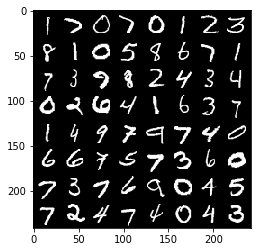

In [13]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(16)))

In [14]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### Define a Conv Net


In [27]:
N=64
C_in=1
H_in=28
Win=28
dilation=1
padding=0
kernel_size=5
C_out=10
stride=1

H_out=np.floor((H_in+2*padding-dilation*(kernel_size-1)-1)/stride)+1
print("H_out", H_out)

print(N,C_out, H_out, H_out)

H_in=H_out
C_in=C_out
kernel_size=2
padding=0
dilation=1
kernel_size=2
stride=2

H_out=np.floor((H_in+2*padding-dilation*(kernel_size-1)-1)/stride)+1
print("H_out", H_out)
print(N,C_out, H_out, H_out)


m = nn.Dropout2d(p=0.2)
input = torch.randn(20, 16, 32, 32)
output = m(input)

print(output.shape)


H_out 24.0
64 10 24.0 24.0
H_out 12.0
64 10 12.0 12.0
torch.Size([20, 16, 32, 32])


In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
        #        dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        
        # Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.max_pool = nn.MaxPool2d(2)
        # ReLU(inplace=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Note: the following two ways for max pooling / relu are equivalent.
        # 1) with torch.nn.functional:
        x=self.conv1(x)
        print("x after conv1",x.shape)
        x=F.max_pool2d(x, 2)
        print("x after max_pool2d", x.shape)
        x = F.relu(x)
        print("x after relu",x.shape)
        
        # 2) with torch.nn:
        x=self.conv2(x)
        print("x after conv2",x.shape)
        x=self.conv2_drop(x)
        print("x after conv2_drop",x.shape)
        x=self.max_pool(x)
        print("x after max_poo;",x.shape)
        x = self.relu(x)
        print("x after relu;",x.shape)
       
        x = x.view(-1, 320)
        print("x after x.view(-1,320)",x.shape)
        x = F.relu(self.fc1(x))
        print("x after x.view(-1,320)", x.shape)
        x = F.dropout(x, training=self.training)
        print(x.shape)
        x = self.fc2(x)
        print(x.shape)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [22]:
from time import time
def train(epoch, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            # bring data to the computing device, e.g. GPU
            data, target = data.to(device), target.to(device)
            print(data.shape)
            print(target.shape)

            # forward pass
            output = model(data)
            # compute loss: negative log-likelihood
            loss = F.nll_loss(output, target)
            
            # backward pass
            # clear the gradients of all tensors being optimized.
            optimizer.zero_grad()
            # accumulate (i.e. add) the gradients from this forward pass
            loss.backward()
            # performs a single optimization step (parameter update)
            optimizer.step()
            
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
            
        end = time()
        print('{:.2f}s'.format(end-start))
        test() # evaluate at the end of epoch

In [23]:
def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

In [26]:
train(5)  # train 5 epochs should get you to about 97% accuracy

torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.315516
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64

torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size

torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size

x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64,

torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size

torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size

torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size

torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1

torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64])
x after conv1 torch.Size([64, 10, 24, 24])
x after max_pool2d torch.Size([64, 10, 12, 12])
x after relu torch.Size([64, 10, 12, 12])
x after conv2 torch.Size([64, 20, 8, 8])
x after conv2_drop torch.Size([64, 20, 8, 8])
x after max_poo; torch.Size([64, 20, 4, 4])
x after relu; torch.Size([64, 20, 4, 4])
x after x.view(-1,320) torch.Size([64, 320])
x after x.view(-1,320) torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size

KeyboardInterrupt: 

## 2. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)
            iteration += 1
        test()
    
    # save the final model
    save_checkpoint('mnist-%i.pth' % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('mnist-4690.pth', model, optimizer)
# should give you the final model accuracy
test()

## 3. Fine-tune a model

Sometimes you want to fine-tune a pretrained model instead of training a model from scratch. For example, if you want to train a model on a new dataset that contains natural images. To achieve the best performance, you can start with a model that's fully trained on ImageNet and fine-tune the model.

Finetuning a model in PyTorch is super easy! First, let's find out what we saved in a checkpoint

In [28]:
# What's in a state dict?
print(model.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


### Finetune the fc layers

Now say we want to load the conv layers from the checkpoint and train the fc layers. We can simply load a subset of the state dict with the selected names

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        # only load the conv layers
        states_to_load[name] = param
print("Number of parameter variables to load:", len(states_to_load))

# Construct a new state_dict in which the layers we want
# to import from the checkpoint is updated with the parameters
# from the checkpoint
model = Net().to(device)
model_state = model.state_dict()
print("Number of parameter variables in the model:", len(model_state))
model_state.update(states_to_load)
        
model.load_state_dict(model_state)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
test() # without fine-tuning.

train(1)  # training 1 epoch will get you to 93%!
# As a comparison, training from scratch for 1 epoch gets about ~80% test accuracy.

### Import pretrained weights in a different model

We can even use the pretrained conv layers in a different model.

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        # same conv layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # fewer FC layers
        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

model = SmallNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
checkpoint = torch.load('mnist-4690.pth')
states_to_load = {}
for name, param in checkpoint['state_dict'].items():
    if name.startswith('conv'):
        states_to_load[name] = param

# Construct a new state dict in which the layers we want
# to import from the checkpoint is update with the parameters
# from the checkpoint
model_state = model.state_dict()
model_state.update(states_to_load)
        
test()

model.load_state_dict(model_state)

In [ ]:
train(1)  # training 1 epoch will get you to ~93%!

### Clean up your code with nn.Sequential

In [ ]:
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()

        # conv layers: feature extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        
        # fc layers: classifier
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)

model = NetSeq().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(5)